# Extracting RDF triples from plain text

## Inroduction

Working on task for creating Linked Open Data using Wikipedia pages led to realization that most of the first sentences of Wikipedia articles often can be distilled to simple statement. For example the descriptor for the Wikipedia itself "Wikipedia is a free online encyclopedia, created and edited by volunteers around the world and hosted by the Wikimedia Foundation." can be read as "Wikipedia is encyclopedia" by removing the decorators (adjectives) and leaving nouns (proper and common in the case) and predicate (aux verb). This lead to the hypothesis that RDF triples can be extracted from raw text.

This notebook contains the first experiments to test this hypothesis. For this goal the experiments are structured as follows:

    - Data collection - three text documents: one fiction, one media (news articles) and one encyclopedic (Wikipedia articles), roughly the same size.
    - Data preparation - sentence splitting, tokenization, lemmatization, POS-tagging of the text documents
    - Run experiments - using two approaches
        * First approach - look for noun -> verb -> noun patterns in sentences
        * Second approach - collect all nouns in the text documents. Create a basic predicate set. Loop the noun and predicatesets to generate noun -> verb -> noun patterns
        



### RDF

The Resource Description Framework (RDF) is a framework for expressing information about resources. It is a standard model for data interchange on the Web recommended by World Wide Web Consortium (W3C). RDF provides a common framework for expressing information on the Web so it can be exchanged between applications without loss of meaning. This means that the information may be made available to applications other than those for which it was originally created.

RDF is used for series of practices including: adding machine-readable information to Web pages, enriching a dataset by linking it to third-party datasets, interlinking API feeds, putting into work the datasets currently published as Linked Data, building distributed social networks, providing a standards-compliant way for exchanging data between databases, interlinking various datasets and enabling cross-dataset queries with the use of SPARQL.

RDF uses International Resource Identifier (IRI) as resource identifies.


### RDF Triples

RDF allows us to make statements about resources. Due their structure of three elements these statements are called triples. The format of these triples is simple and always has the following structure:

    <subject> <predicate> <object>

For example:

    <Bob> <is a> <person>.
    <Bob> <is a friend of> <Alice>.
    <Bob> <is born on> <the 4th of July 1990>.

The RDF statements expresses a relationship between two resources. The subject and the object represent the two resources being related; the predicate represents the nature of their relationship.

### the Turtle Language

the Terse RDF Triple Language or simply Turtle allows for the textual representations of an RDF graphs. Turtle introduces a number of syntactic shortcuts, such as support for namespace prefixes, lists and shorthands for datatyped literals. This language provides a trade-off between ease of writing, ease of parsing and readability.

Turtle examlpe:

    @base <http://example.org/> .
    @prefix rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#> .
    @prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#> .
    @prefix foaf: <http://xmlns.com/foaf/0.1/> .
    @prefix rel: <http://www.perceive.net/schemas/relationship/> .

    <#green-goblin>
        rel:enemyOf <#spiderman> ;
        a foaf:Person ;    # in the context of the Marvel universe
        foaf:name "Green Goblin" .

    <#spiderman>
        rel:enemyOf <#green-goblin> ;
        a foaf:Person ;
        foaf:name "Spiderman", "Человек-паук"@ru .

This example introduces many of features of the Turtle language: @base and Relative IRI references, @prefix and prefixed names, predicate lists separated by ';', object lists separated by ',', the token a, and literals. Comments may be given after a '#'.

### Knowledge Graphs

Knowedge graphs use the core idea that data/knowledge can be represented in the form of a abstraction upon real-world entities (nodes) and relations between them (edges). Graphs allow for the data and its scope to evolve in a flexible manner. The query languages for graphs support
not only standard relational operators (joins, unions, projections, etc.), but also navigational operators.

Knowledge graphs are often assembled from various sources and can be highly diverse in terms of structure and granularity as a result. With the use of schemas, which define a high-level structure for the graphs, and context, which indicates in what setting some unit of knowledge is held true. Knowledge graph to grow and improve over time with the use of methods like extraction, enrichment, quality assessment and refinement.

Knowledge can be stored in the graphs as simple statements, such as “Sofia is the capital of Bulgaria” and “all capitals are cities”. Later deductive and inductive methods can be implemented to accumulate further knowledge: if Sofia is capital and capital is city ergo “Sofia is a city”.

## Data

To install spaCy run "conda install -c conda-forge spacy" and then "python -m spacy download en_core_web_sm" in the anaconda terminal

In [100]:
import spacy
from nltk import word_tokenize, sent_tokenize, pos_tag
from nltk.stem import WordNetLemmatizer
from nltk import download as nltk_down
import re
import networkx as nx
import matplotlib.pyplot as plt

### Input

The data consists of three documents:
- fiction text - The Phoenix on the Sword by Robert E. Howard available via [Project Gutenberg of Australia](http://www.gutenberg.net.au/ebooks06/0600811h.html).
- media text - 14 articles from Reuters and DW, all from 02.08.2023.
- enciclopedic text - around 30 Wikipedia articles from different domains: Biology, Geography, Physics and Chemistry.

Let's make a function that loads our files.

In [2]:
def load_input_file(file):
    text = ''
    with open(file, 'r', encoding='utf-8-sig') as input_file:
        text = input_file.read()
    return text

After loading the text documents we can see the number of characters in each document or some regular expressions to measure the size of the documents in words. The word count should be similar for each of the documents.

In [3]:
fiction_text = load_input_file('data/conan.txt')
fiction_words = re.split("\W+", fiction_text)

In [4]:
media_text = load_input_file('data/media.txt')
media_words = re.split("\W+", media_text)

In [5]:
wiki_text = load_input_file('data/wiki.txt')
wiki_words = re.split("\W+", wiki_text)

In [6]:
print(f"Character counts: fiction - {len(fiction_text)}, media - {len(media_text)}, wiki - {len(wiki_text)}")
print(f"RE word counts: fiction - {len(fiction_words)}, media - {len(media_words)}, wiki - {len(wiki_words)}")

Character counts: fiction - 50253, media - 57779, wiki - 63848
RE word counts: fiction - 9186, media - 9597, wiki - 10219


Character counts are not very informative and matching with regular expressions is prone to errors. For text processing is better to look for sentences and words. This can be done wit the help of NLTK and spaCy libraries. They can apply the processes of sentence splitting and tokenization (taking a text or sentence and splitting it into individual units called tokens).

In [7]:
fiction_tokens = word_tokenize(fiction_text)
media_tokens = word_tokenize(media_text)
wiki_tokens = word_tokenize(wiki_text)

In [8]:
nltk_counts = f"NLTK word counts: fiction - {len(fiction_tokens)}, media - {len(media_tokens)}, wiki - {len(wiki_tokens)}"

Ok, the there is a difference. Maybe an arbiter will help. What will spaCy count.
First load the model, then make the document and see the tokens.

In [9]:
nlp = spacy.load("en_core_web_sm")

In [10]:
fiction_doc = nlp(fiction_text)
media_doc = nlp(media_text)
wiki_doc = nlp(wiki_text)

In [11]:
spacy_counts = f"spaCy word counts: fiction - {len(fiction_doc)}, media - {len(media_doc)}, wiki - {len(wiki_doc)}"
print(spacy_counts)
print(nltk_counts)

spaCy word counts: fiction - 11041, media - 11206, wiki - 11897
NLTK word counts: fiction - 10585, media - 10728, wiki - 11586


It seem that NLTK and spaCy tokenizers are producing different token counts. Lets see the outputs:

In [12]:
nltk_result = []
for nltk_token in wiki_tokens[:20]:
    nltk_result.append(nltk_token)

spacy_result = []
for spacy_token in wiki_doc[:20]:
    spacy_result.append(spacy_token)


In [13]:
print(nltk_result)
print(spacy_result)

['Turtles', 'are', 'an', 'order', 'of', 'reptiles', 'known', 'as', 'Testudines', ',', 'characterized', 'by', 'a', 'shell', 'developed', 'mainly', 'from', 'their', 'ribs', '.']
[Turtles, are, an, order, of, reptiles, known, as, Testudines, ,, characterized, by, a, shell, developed, mainly, from, their, ribs, .]


This looks fine. Lets try with the number of sentences.

In [14]:
fiction_sents = sent_tokenize(fiction_text)
media_sents = sent_tokenize(media_text)
wiki_sents = sent_tokenize(wiki_text)

In [15]:
nltk_sentences = f"NLTK sentence counts: fiction - {len(fiction_sents)}, media - {len(media_sents)}, wiki - {len(wiki_sents)}"

In [16]:
fiction_spacy_sent = list(fiction_doc.sents)
media_spacy_sent = list(media_doc.sents)
wiki_spacy_sent = list(wiki_doc.sents)

In [17]:
spacy_sentences = f"spaCy sentence counts: fiction - {len(fiction_spacy_sent)}, media - {len(media_spacy_sent)}, wiki - {len(wiki_spacy_sent)}"

In [18]:
print(nltk_sentences)
print(spacy_sentences)

NLTK sentence counts: fiction - 565, media - 433, wiki - 486
spaCy sentence counts: fiction - 527, media - 434, wiki - 485


Close enough. It seems that the splitters disagree most in the fiction document.

### Preprocessing

For the purposes of the experiments the text will need to be separated into sentences and tokes. Then the tokens will need to be lemmatized and recieve part-of-speech-tags.

Lemmatisation is the process of grouping together the inflected forms of a word so they can be analysed as a single item and Part-of-speech (POS) tagging is the assignment of part-of-speech tags to words.

Trying to measure the size of the documents the separation work is done. NLTK does lemmatization and POS-tagging via separate methods while spaCy does all at doc creation.

Lets begin with NLTK lemmatization.


In [19]:
# load once for lemmatizer to work
#nltk_down('omw-1.4')

Start by creating a function that takes the tokens and utilizes a lemmatizer from NLTK. The WordNet one is recommended, but other are available. 

In [20]:
lemmatizer = WordNetLemmatizer()

def lematize_tokens(tokens):
    lemmas = []

    for token in tokens:
        lemmetized_word = lemmatizer.lemmatize(token)
        lemmas.append(lemmetized_word)

    return lemmas

Lematize the texts.

In [21]:
fiction_lemmas = lematize_tokens(fiction_tokens)
media_lemmas = lematize_tokens(media_tokens)
wiki_lemmas = lematize_tokens(wiki_tokens)

Implement POS-tagging to the lemmatized texts.

In [22]:
fiction_pos = pos_tag(fiction_lemmas)
media_pos = pos_tag(media_lemmas)
wiki_pos = pos_tag(wiki_lemmas)

Check results.

In [23]:
media_pos[:20]

[('HONG', 'NNP'),
 ('KONG/BEIJING', 'NNP'),
 (',', ','),
 ('Aug', 'NNP'),
 ('2', 'CD'),
 ('(', '('),
 ('Reuters', 'NNPS'),
 (')', ')'),
 ('-', ':'),
 ('Some', 'DT'),
 ('Chinese', 'JJ'),
 ('city', 'NN'),
 ('government', 'NN'),
 ('have', 'VBP'),
 ('made', 'VBN'),
 ('it', 'PRP'),
 ('harder', 'JJR'),
 ('for', 'IN'),
 ('developer', 'NN'),
 ('to', 'TO')]

This should do it. Now to proceed with the triple extraction.

## Extracting and Generating Triples

NLTK and spaCy behave differently so they will be implemented separately and their results will be compared.

### Extracting Triples

From the text. Look for target predicates. Look for nouns before and after the predicate.

Pack the logic in a function.

In [24]:
def nltk_extract_triples(pos_tokens):
    nltk_triples = []

    for idx, tup in enumerate(pos_tokens):
        if tup[0] in ['is', 'are', 'have', 'can']:
            predicate = tup[0]
            subj = ''
            obj = ''
            
            for i in range(idx, -1, -1):
                if pos_tokens[i][1].startswith('NN'):
                    subj = pos_tokens[i][0]
                    break
            for j in range(idx, len(pos_tokens)):
                if pos_tokens[j][1].startswith('NN'):
                    obj = pos_tokens[j][0]
                    break

            triple = f"{subj.lower()} {predicate} {obj.lower()}"
            nltk_triples.append(triple)

    return nltk_triples

Run the function with texts.

In [25]:
fiction_triples_nltk = nltk_extract_triples(fiction_pos)
media_triples_nltk = nltk_extract_triples(media_pos)
wiki_triples_nltk = nltk_extract_triples(wiki_pos)

Check results.

In [26]:
print(len(wiki_triples_nltk))
wiki_triples_nltk[:20]

391


['turtles are order',
 'turtle are group',
 'head are living',
 'terrapin are continent',
 'shell are bone',
 'part is carapace',
 'underside is flatter',
 'surface is scale',
 'turtles are temperature',
 'environment are omnivore',
 'turtle are reptile',
 'turtles have myth',
 'specie are pet',
 'turtles have meat',
 'turtle are bycatch',
 'world are result',
 'specie are extinction',
 'hedgehog is mammal',
 'erinaceidae are specie',
 'introduction are australia']

Repeat the process for spaCy.

In [27]:
def spacy_extract_triples(document):
    spacy_triples = []

    for token in document:
        if token.lemma_ in ['be', 'have', 'can']:
            idx = token.i
            predicate = token
            subj = ''
            obj = ''

            for i in range(idx, -1, -1):
                if document[i].pos_ == "NOUN":
                    subj = document[i].lemma_
                    break
            for j in range(idx, len(document)):
                if document[j].pos_ == "NOUN":
                    obj = document[j].lemma_
                    break

            triple = f"{subj} {predicate} {obj}"
            spacy_triples.append(triple)

    return spacy_triples

In [28]:
fiction_triples_spacy = spacy_extract_triples(fiction_doc)
media_triples_spacy = spacy_extract_triples(media_doc)
wiki_triples_spacy = spacy_extract_triples(wiki_doc)

In [29]:
print(len(wiki_triples_spacy))
wiki_triples_spacy[:20]

533


['turtle are order',
 'turtle are group',
 'head are living',
 'terrapin are continent',
 'shell are bone',
 'part is carapace',
 'underside is plastron',
 'surface is scale',
 'turtle are ectotherm',
 'environment are omnivore',
 'turtle are reptile',
 'turtle have myth',
 'specie are pet',
 'turtle have meat',
 'turtle been meat',
 'turtle are bycatch',
 'world are result',
 'world being result',
 'specie are extinction',
 'hedgehog is mammal']

Comparison of the number and a sample of the extracted triples between NLTK and spaCy:

In [30]:
print(len(fiction_triples_nltk))
print(fiction_triples_nltk[:10])
print(len(fiction_triples_spacy))
print(fiction_triples_spacy[:10])


99
['dupe have street', 'desert have heart', 'night have agent', 'agent have face', 'face have empire', 'shadow have downfall', 'task is wit', 'task are wit', 'deed is people', 'reign is people']
333
['rise was age', 'world was supreme', 'countenance was door', 'hand was giant', 'dupe have street', 'desert have heart', 'desert been heart', 'night have noble', 'agent have face', 'face have empire']


In [31]:
print(len(media_triples_nltk))
print(media_triples_nltk[:10])
print(len(media_triples_spacy))
print(media_triples_spacy[:10])

199
['government have developer', 'move are completion', 'sale are future', 'sector is tightening', 'project can developer', 'project is developer', 'developer have crisis', 'sector have capital', 'efficiency can credit', 'developer are project']
440
['government have developer', 'company be move', 'move are completion', 'sale are future', 'sector is tightening', 'government has help', 'sector has year', 'sector been year', "demand 's dilemma", 'project can developer']


In [32]:
print(len(wiki_triples_nltk))
print(wiki_triples_nltk[:10])
print(len(wiki_triples_spacy))
print(wiki_triples_spacy[:10])

391
['turtles are order', 'turtle are group', 'head are living', 'terrapin are continent', 'shell are bone', 'part is carapace', 'underside is flatter', 'surface is scale', 'turtles are temperature', 'environment are omnivore']
533
['turtle are order', 'turtle are group', 'head are living', 'terrapin are continent', 'shell are bone', 'part is carapace', 'underside is plastron', 'surface is scale', 'turtle are ectotherm', 'environment are omnivore']


The results show some overlap and few discrepances. Sets can be used to make the differences visible.

In [33]:
fiction_diff = set(fiction_triples_nltk) - set(fiction_triples_spacy)
media_diff = set(media_triples_nltk) - set(media_triples_spacy)
wiki_diff = set(wiki_triples_nltk) - set(wiki_triples_spacy)

In [34]:
print(len(fiction_diff))
fiction_diff

53


{'ah is ring',
 'ancient is men',
 'ascalante can conan',
 'ascalante can well',
 'ascalante is city',
 'back are be',
 'bossonians have aid',
 'cimmeria are goblet',
 'cimmeria is war',
 'commander is ascalante',
 'conan can power',
 'conan is power',
 'country have conan',
 'darkness have material',
 'destiny is aquilonia',
 'eye is something',
 'foreigner can mitra',
 'gigantic are web',
 'god are crom',
 'god is ymir',
 'golamira is mysteries',
 'grass is unrest',
 'high-priests is word',
 'king is conan',
 'king is feet—and—',
 'land is cimmeria',
 'luck can volmana',
 'luck have volmana',
 'man have conan',
 'men are folk',
 'men are world',
 'men is set',
 'neophyte is power',
 'night are a',
 'night are prospero',
 'night have agent',
 'north are faulty',
 'people are black',
 'picts have so',
 'plot can ascalante',
 'poets—who is ascalante',
 'poitainian are part',
 'publius can poets—who',
 'rinaldo is prospero',
 'rinaldo is torch',
 'slumber have conan',
 'stand can epemitr

In [35]:
print(len(media_diff))
media_diff

76


{'africa is home',
 'arms have protest',
 'arrangement is december',
 'battle is war',
 'brother is pro-overhaul',
 'caicedo have expectation',
 'caicedo is football',
 'canteen can share',
 'change is alternative',
 'china have way',
 'china is devastation',
 'china is energy',
 'colombians are colombians',
 'company is semtex',
 'country have celsius',
 'court are israel',
 'demand is china',
 'ecowas have sahel',
 'energy is kenya',
 'eu is economy',
 'eu is philippines',
 'eu is trade',
 'everything are lot',
 'fahrenheit are degree',
 'faso have government',
 'february is von',
 'football are caicedo',
 'fund have source',
 'game have hospitals',
 'germany is one',
 'germany is —',
 'government is sos',
 'hospitals have alert',
 'hynek have population',
 'indo-pacific are cooperation',
 'industry are thanks',
 'iran are desert',
 'island is khanun',
 'issue is arm',
 'japan have typhoon',
 'kenya have source',
 'kenya is energy',
 'kenya is game-changer',
 'krämer is improvement',

In [36]:
print(len(wiki_diff))
wiki_diff

162


{"'neck is piece",
 'acer is genus',
 'america is ulsd',
 'apples have significance',
 'apples have thousand',
 'asia is yew',
 'asterism are definition',
 'astronomers can mass',
 'astronomers have star',
 'average are parrot',
 'b have earth',
 'berries—they are ingredient',
 'bike is combustion',
 'blue is water',
 'branch is genus',
 'breeze can gasoline',
 'caballus is mammal',
 'canals are isthmus',
 'car are le',
 'cars have control',
 'cattle are africa',
 'cattle are europe',
 'cattle are india',
 'cattle are livestock',
 'cattle are source',
 'chemical are chemical',
 'chemist have science',
 'climate is cooler',
 'cockatoos are bird',
 'cockatoos are crest',
 'cockatoos are hollow',
 'constellation are aratus',
 'continue is plastic',
 'cvt is transmission',
 'cycle is vehicle',
 'difference is δ',
 'domestication have bc',
 'domestication is bc',
 'earth are city',
 'earth have mass',
 'earth is mount',
 'earth is sun',
 'engine is rating',
 'equidae is subspecies',
 'erina

Both NLTK and spacy tokenizers and lemmatizers are not errorless.

The difference of lemmatization leads to strange behavior of the aux verbs. It is possible that behavior to be the reason for spaCy extractor to produce that much more triples. 

The NLTK preprocessing marked a lone dash as noun.

### Generating Triples

Lets try to generate some more triples. It is possible to use a similar approach as the extraction. 

First step will be the extraction of all nouns in the texts, the a set of the same predicates will be added. Finally every noun will be mached with every predicate as subject and object.

In [37]:
def collect_nouns_nltk(pos_tokens):
    nouns = set()
    for lemma, pos_tag in pos_tokens:
        if pos_tag.startswith('NN'):
            nouns.add(lemma.lower())
    return nouns

In [38]:
fiction_nouns_nltk = collect_nouns_nltk(fiction_pos)
media_nouns_nltk = collect_nouns_nltk(media_pos)
wiki_nouns_nltk = collect_nouns_nltk(wiki_pos)

In [39]:
print(len(fiction_nouns_nltk))
list(fiction_nouns_nltk)[:20]

1036


['kings',
 'smooth',
 'door',
 'prospero',
 'whole',
 'swordsman',
 'helmet',
 'statesman',
 'blind',
 'dawn',
 'assail—thanks',
 'action',
 'way',
 'valley',
 'leather',
 'rushing',
 'volmana',
 'see',
 'resting-place',
 'housetop']

In [40]:
def collect_nouns_spacy(document):
    nouns = set()
    for token in document:
        if token.pos_ == "NOUN":
            nouns.add(token.lemma_)
    return nouns

In [41]:
fiction_nouns_spacy = collect_nouns_spacy(fiction_doc)
media_nouns_spacy = collect_nouns_spacy(media_doc)
wiki_nouns_spacy = collect_nouns_spacy(wiki_doc)

In [42]:
print(len(fiction_nouns_spacy))
list(fiction_nouns_spacy)[:20]

796


['prey',
 'door',
 'helmet',
 'swordsman',
 'statesman',
 'dawn',
 'action',
 'leather',
 'way',
 'valley',
 'rushing',
 'housetop',
 'youth',
 'vampire',
 'goblet',
 'garment',
 'panel',
 'name',
 'plate',
 'impatience']

Check the common and the different elements in the noun sets.

In [58]:
fiction_nouns_intersection = list(fiction_nouns_nltk & fiction_nouns_spacy)


In [59]:
fiction_nouns_diff = list(fiction_nouns_nltk.difference(fiction_nouns_spacy))


In [60]:
print(len(fiction_nouns_intersection))
fiction_nouns_intersection[:20]

714


['door',
 'helmet',
 'swordsman',
 'statesman',
 'dawn',
 'action',
 'leather',
 'valley',
 'way',
 'rushing',
 'housetop',
 'youth',
 'vampire',
 'goblet',
 'garment',
 'panel',
 'name',
 'impatience',
 'silver',
 'finger']

In [61]:
print(len(fiction_nouns_diff))
fiction_nouns_diff[:20]

322


['kings',
 'smooth',
 'whole',
 'prospero',
 'blind',
 'assail—thanks',
 'volmana',
 'see',
 'high-priests',
 'go',
 'atlantis',
 'undreamed',
 'shadowy',
 'gigantic',
 'unseen',
 'king—if',
 'melting',
 'karaban',
 'thune',
 'stygia']

Finaly unite the noun sets from the two models.

In [47]:
fiction_nouns_all = list(fiction_nouns_nltk | fiction_nouns_spacy)
media_nouns_all = list(media_nouns_nltk | media_nouns_spacy)
wiki_nouns_all = list(wiki_nouns_nltk | wiki_nouns_spacy)


In [48]:
fiction_nouns_all[:20]

['door',
 'blind',
 'dawn',
 'assail—thanks',
 'action',
 'way',
 'valley',
 'volmana',
 'youth',
 'panel',
 'goblet',
 'name',
 'go',
 'undreamed',
 'shadowy',
 'gigantic',
 'plate',
 'king—if',
 'silver',
 'finger']

Use the same predicate set as the extraction:

In [49]:
predicates = ['is', 'have', 'can']

Generative function. Make sure that one noun is not simultaneously subject and object.

In [50]:
def generate_triples(nouns, predicates):
    triples = []
    for subj in nouns:
        for predicate in predicates:
            for obj in nouns:
                if subj != obj:
                    triple = f"{subj} {predicate} {obj}"
                    triples.append(triple)
    return triples

In [51]:
fiction_generated_triples = generate_triples(fiction_nouns_all, predicates)
media_generated_triples = generate_triples(media_nouns_all, predicates)
wiki_generated_triples = generate_triples(wiki_nouns_all, predicates)

In [52]:
print(len(media_generated_triples))
media_generated_triples[:20]

5382780


["planet' is ng",
 "planet' is taiwan",
 "planet' is monday",
 "planet' is covid-19",
 "planet' is cold",
 "planet' is environment",
 "planet' is breach",
 "planet' is garissa",
 "planet' is action",
 "planet' is way",
 "planet' is pakain",
 "planet' is news",
 "planet' is brazil",
 "planet' is controller",
 "planet' is iran",
 "planet' is fixture",
 "planet' is panel",
 "planet' is france",
 "planet' is footage",
 "planet' is technology"]

The triple lists are slow and with millions of elements. Save them as turtle files.

In [53]:
def save_triples(triples, file_name):
    with open(f'results/{file_name}.ttl', 'w') as output_file:
        for triple in triples:
            output_file.write(f'{triple} .\n')


Do it the first time. After that the files can be loaded.

In [54]:
# save_triples(fiction_generated_triples, 'fiction_triples')
# save_triples(media_generated_triples, 'media_triples')
# save_triples(wiki_generated_triples, 'wiki_triples')

Lets also save the extracted triples as turtle files.

In [55]:
# save_triples(fiction_triples_nltk, 'fiction_triples_extracted_nltk')
# save_triples(fiction_triples_spacy, 'fiction_triples_extracted_spacy')

In [56]:
# save_triples(media_triples_nltk, 'media_triples_extracted_nltk')
# save_triples(media_triples_spacy, 'media_triples_extracted_spacy')

In [57]:
# save_triples(wiki_triples_nltk, 'wiki_triples_extracted_nltk')
# save_triples(wiki_triples_spacy, 'wiki_triples_extracted_spacy')

## Graph Representation

The turtle files are considered RDF graphs, but they are not easily readable. Lets try to visualize them.

First create a small sample for representation (manually curated).

In [104]:
example_triples = ['shell are bone .', 'surface is scale .', 'turtle are reptile .', 'hedgehog is mammal .', 'cockatoo is parrot .', 'plumage is colourful .', 'cattle are livestock .', 'point can build-up .']

In this example, each triple is split into its subject, predicate, and object components. Then the NetworkX library is used to to create a directed graph and nodes for subjects and objects and edges between are added. Finally some visualization parameters are adjusted.

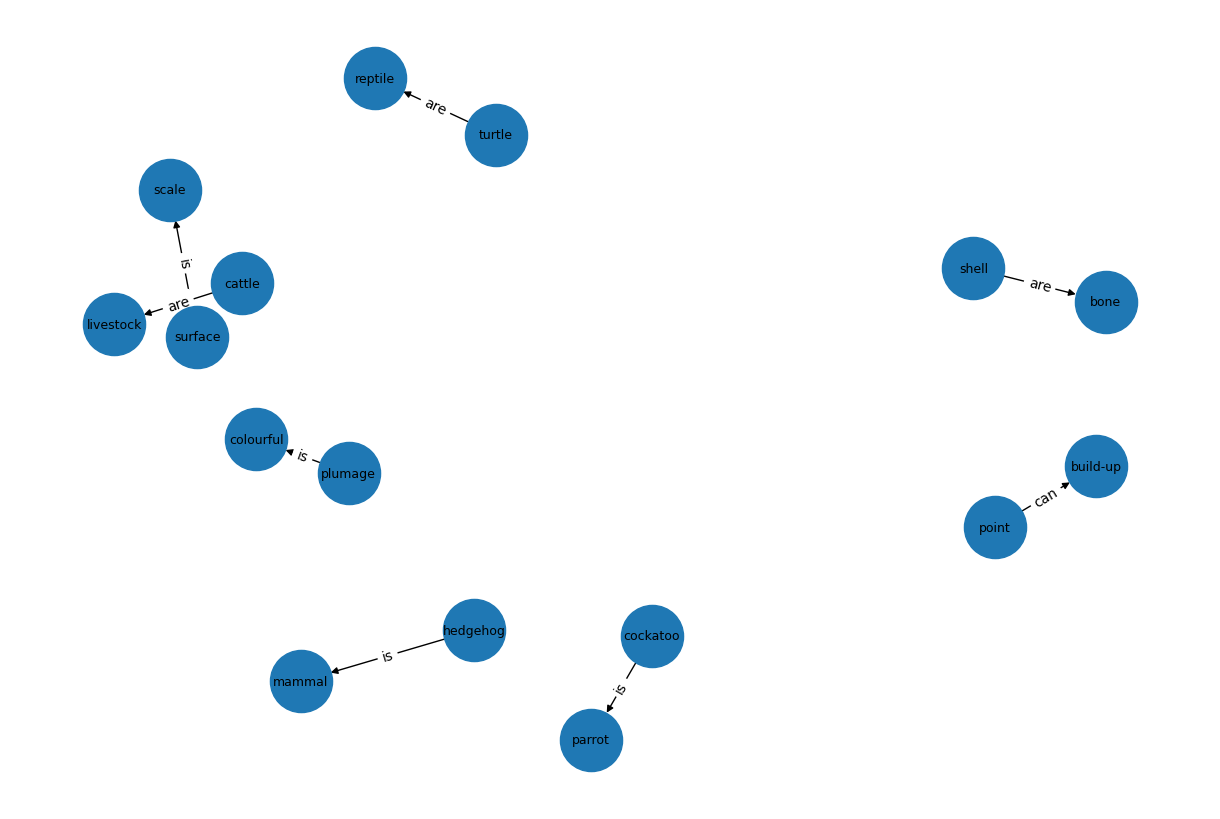

In [110]:
GRAPH = nx.DiGraph()

for triple in example_triples:
    parts = triple.split(' ')
    subject = parts[0]
    predicate = parts[1]
    object = parts[2]
    
    GRAPH.add_node(subject)
    GRAPH.add_node(object)
    GRAPH.add_edge(subject, object, label=predicate)

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(GRAPH, seed=42, k=0.5)
labels = nx.get_edge_attributes(GRAPH, 'label')
nx.draw(GRAPH, pos, with_labels=True, node_size=2000, font_size=9)
nx.draw_networkx_edge_labels(GRAPH, pos, edge_labels=labels)
plt.show()

## Conclusion

The aim of this notebook is to test the hypothesis that it is possible to extract real live knowledge from real live text documents i nte form of RDF triples. Such extraction is possible and produces decent statements, but also leads to some challenges.

There is need for triple validation. Manual or automated process of filtering "wrong" triples. How to define such triples and how deal with them - editing or deletion? At the moment they are validated manually. It will be interesting to calculate the percentage of valid against invalid triples. 

Categorization of produced triples: good example - "hedgehog is mammal"; interesting example - "specie are extinction"; bad example - "world are result". The interesting examples capture some real life knowledge, but skewed. Compare "specie are extinction" to "specie can_be extinct" or "specie is extinct". The bad examples are just untrue.

The initial set of predicates both for extraction and for generation is extremely basic. Determining the members of the set is problematic on it's own. For future experiments it will be beneficial to check the most commonly used RDF schemas.

In this first implementation the generator function encompass every triple case and is overgenerating. The logic for generation needs refinement, more rules and/or inclusion of validation before saving the results.

As expected the encyclopedic text produces the most triples and the fiction text is the least productive. That does not mean that fiction text do not produce any triples. The three tested documents produced valid statements.


## References

1. [RDF](https://www.w3.org/RDF/)
2. [RDF Primer](https://www.w3.org/TR/2014/NOTE-rdf11-primer-20140624/)
3. [RDF Triples](https://www.w3.org/TR/rdf12-n-triples/)
4. [Turtle Format](https://www.w3.org/TR/rdf12-turtle/)
4. [Declarative RDF graph generation](https://www.sciencedirect.com/science/article/pii/S1570826822000373)
5. [Entity extraction: From unstructured text to DBpedia RDF triples](https://lucris.lub.lu.se/ws/portalfiles/portal/3053000/3191702.pdf)
6. [FactCheck: Validating RDF Triples Using Textual Evidence](https://svn.aksw.org/papers/2018/CIKM_FACTCHECK/public.pdf)
7. [Harvesting RDF triples](https://citeseerx.ist.psu.edu/document?repid=rep1&type=pdf&doi=05620dd4b5346e5c17f3f4da97efcb18e2fcb7e6)
8. [Knowledge Graphs](https://arxiv.org/pdf/2003.02320.pdf)
8. [NLTK](https://www.nltk.org/)
9. [Install spaCy](https://spacy.io/usage)
10. [NLP with spaCy](http://spacy.pythonhumanities.com/intro.html)
